# Pneumonia Classification in PyTorch - Data Preprocessing
* Notebook by Adam Lang, Springboard Data Science Fellow
* Date: 5/6/2024
* This notebook will go through the preprocessing steps for building a deep learning classication model to classify pneumonia on chest x-rays using PyTorch.

# Pneumonia - Medical Overview
* Very common infectious disease
* In 2017, 1.3 million people were diagnosed in the USA.
    * Over 50,000 deaths every year.
    * Fatality rate of ~4%
    * **Life threatening if not diagnosed and treated in time**


# Dataset Overview
* RSNA Pneumonia Detection Challenge
* Kaggle link: https://www.kaggle.com/competitions/rsna-pneumonia-detection-challenge/data
* The data consists of:
    * 26,684 total X-RAY images of pneumonia pathology
    * 20,672 images **without** pneumonia -> 77.4% of data
    * 6,012 images **with** pneumonia -> 22.5% of data


# Data Preprocessing Overview and Routine
* Original shape of images is 1024x1024
    * Too large for machine learning algorithms
    * We will need to resize the images to 224x224
* Standardize pixel values into interval between 0 and 1 or `[0,1]` by scaling with constant factor of 1/255
    * Multiply all pixels with this standard constant.
* Split dataset into:
    * Train set: 24,000 images
    * Validation set: 2,684 images
* Store converted images in folders corresponding to each binary class:
    * 0 if no pneumonia
    * 1 if pneumonia
* Compute training set mean and standard deviation for normalization of data
    * Why? **Dataset does not fit into memory**
        * This "trick" is thus used to compute mean and standard deviation
        * Compute sum of x and sum of x**2 for each image X and add these values to the global variable sums and sums_squared.
        * This is done for all pixels.
        * Equation:


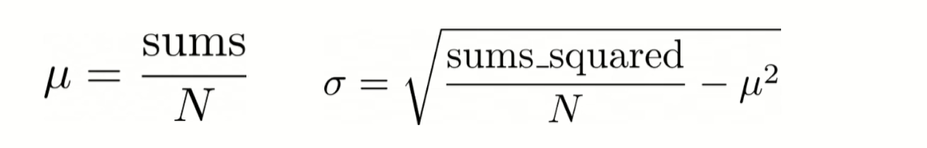



# Dataset - code details
* We will utilize `torchvision.DatasetFolder`
    * No need for custom dataset classes!
* Z-normalize images with computed mean and std
    * Xnorm = X - μ / σ
    * (from all pixel values)
* Apply data augmentation process for all images:
    * Random rotations
    * Random translations
    * Random scales
    * Random resized crops

# Training - Overview
* PyTorch Lightning
    * high-level PyTorch wrapper for simple and effective training.
    * No manual implementation of training loop needed!
    * Automatically handles (Multi-)GPU
    * Simple logging and callback interfaces
    * **Full access to all variables and parameters!**

# Model Details
* Neural Network Architecture
    * **ResNet18**
        * Paper: https://arxiv.org/abs/1512.03385
        * Change input channels from 3 to 1
            * Medical images are not in RGB format
        * Change output dimension from 1000 to 1
            * We only need 1 output (if image is positive for pneumonia!)

    * Loss Function: `BCEWithLogitsLoss`
        * Apply directly to logits (raw predictions of neural net model)
        * Negative output --> No pneumonia
    * Optimizer
        * Adam (lr=1e-4)
    * Train for 30 epochs

# Interpretability
* Why does our model trained output **"Pneumonia"** for a given x-ray image?
  * We will find out by extracting the image region with the largest influence on the prediction.
      * Which part of the image supports the classifier the most in its prediction?
  * Compute Class Activation Map (CAM)

# Class Activation Maps
* Class activation maps can help explain the predictions of a ConvNet.
* Class activation maps, commonly called **CAMs**, are class-discriminative saliency maps.
* While saliency maps give information on the most important parts of an image for a particular class, class-discriminative saliency maps help **distinguish between classes.**
* Each layer of the Convolutional neural net consists of a CNN filter.
    * Thus if there are n layers --> there are n feature mapsThe activation map for a particular output class is the weighted combination of all the n feature maps.
    * Source: https://www.pinecone.io/learn/class-activation-maps/


## Class Activation Maps - Process
* Extract output A (features) with k filters of the last convolutional layer of the model
* Extract weights w of the fully connected layer
* Compute the dot product between A and w
      * Μ = ∑_ₖ wₖAₖ

* In code:

* `cam = torch.zeros((features.width * features.height))`
* `for i in range(len(cam)):`
* `cam[i] = torch.sum(weight*features[:,i])`


### Class Activation Map Example
* The map highlights the pneumonia.
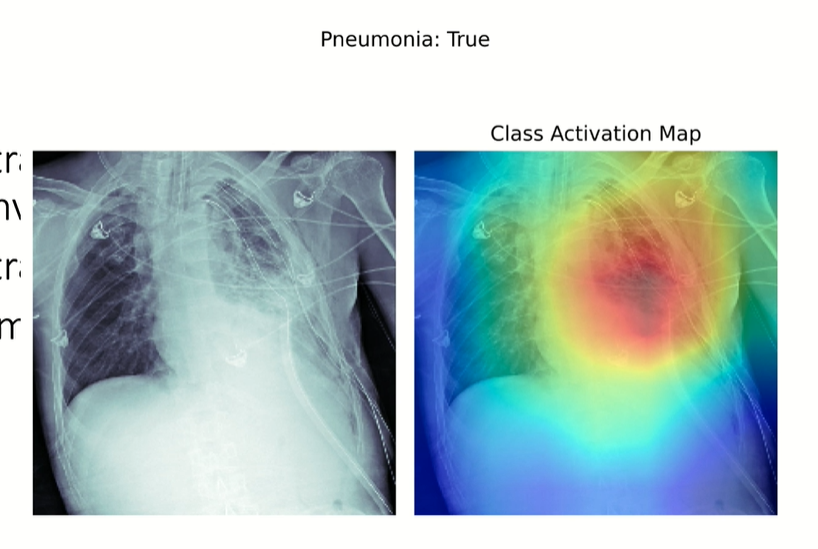

# Class Activation Map -- Restrictions
* Only works with CNNs
* Needs specific structure:
    * Convolution --> Global average pooling --> Fully Connected layer
    * Only works on networks with single FC layer
* Alternatives (for non CNNs):
    * GradCAM
    * GradCAM++
    * ScoreCAM

# 1. Preprocessing

* We will train a classifier to predict whether an X-Ray of a patient shows signs of pneumonia or not based on the RSNA Pneumonia Detection Challenge (https://www.kaggle.com/c/rsna-pneumonia-detection-challenge).

* At first we download the data from kaggle (https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data), by clicking on "Download All" and extract it afterwards.

* Acknowledgements: Wang X, Peng Y, Lu L, Lu Z, Bagheri M, Summers RM. ChestX-ray8: Hospital-scale Chest X-ray Database and Benchmarks on Weakly-Supervised Classification and Localization of Common Thorax Diseases. IEEE CVPR 2017, http://openaccess.thecvf.com/content_cvpr_2017/papers/Wang_ChestX-ray8_Hospital-Scale_Chest_CVPR_2017_paper.pdf

* Original Source: https://nihcc.app.box.com/v/ChestXray-NIHCC

In [1]:
# install pydicom
!pip install pydicom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.9 MB/s eta 0:00:00


In [2]:
# imports
from pathlib import Path
# pydicom work with DICOM images
import pydicom
import numpy as np
# resize images
import cv2
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.notebook import tqdm

## Read in train data set labels
* `stage_2_train_labels.csv`

In [3]:
## data path
labels_data_path = '/content/drive/MyDrive/Colab Notebooks/Deep Learning PyTorch Medical Image Analysis/AI-IN-MEDICAL-MATERIALS_NEW/AI-IN-MEDICAL-MATERIALS/04-Pneumonia-Classification/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv'

In [4]:
# read in labels data
labels = pd.read_csv(labels_data_path)

In [5]:
# head of labels df
labels.head(6)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1


In [6]:
## print labels target
labels.Target.value_counts()

Target
0    20672
1     9555
Name: count, dtype: int64

In [7]:
## labels df info
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


In [8]:
# dtypes
labels.dtypes

patientId     object
x            float64
y            float64
width        float64
height       float64
Target         int64
dtype: object

Note about dtypes:
* The current dtypes for variables `x`, `y`, `width`, and `height` are **float64**. The default dtype for PyTorch is float32.
* We will convert the dtypes to **float16** for easier memory storage.

In [9]:
## labels describe
labels.describe()

,x,y,width,height,Target
count,9555.000000,9555.000000,9555.000000,9555.000000,30227.000000
mean,394.047724,366.839560,218.471376,329.269702,0.316108
std,204.574172,148.940488,59.289475,157.750755,0.464963
min,2.000000,2.000000,40.000000,45.000000,0.000000
25%,207.000000,249.000000,177.000000,203.000000,0.000000
50%,324.000000,365.000000,217.000000,298.000000,0.000000
75%,594.000000,478.500000,259.000000,438.000000,1.000000
max,835.000000,881.000000,528.000000,942.000000,1.000000


Summary of data:
* We can see the following:
    * PatientID
    * x and y coordinates where pneumonia occurs
    * Target -> binary variable for pneumonia present
    * Interesting as well that we can see for the Target variable right now that there are significantly more 0s (no pneumonia) than 1s (with pneumonia).
    * The mean height and width of the images is 216 x 314.
* Note: There is duplicate data here!

## Drop any duplicate records




In [10]:
labels = labels.drop_duplicates("patientId")

## Set up ROOT_PATH for train data images

In [11]:
train_path = '/content/drive/MyDrive/Colab Notebooks/Deep Learning PyTorch Medical Image Analysis/AI-IN-MEDICAL-MATERIALS_NEW/AI-IN-MEDICAL-MATERIALS/04-Pneumonia-Classification/rsna-pneumonia-detection-challenge/stage_2_train_images'

In [12]:
ROOT_PATH = Path(train_path)
SAVE_PATH = Path("Processed") #directory

## Visualize some images
* We will need to set up a for loop to do this.

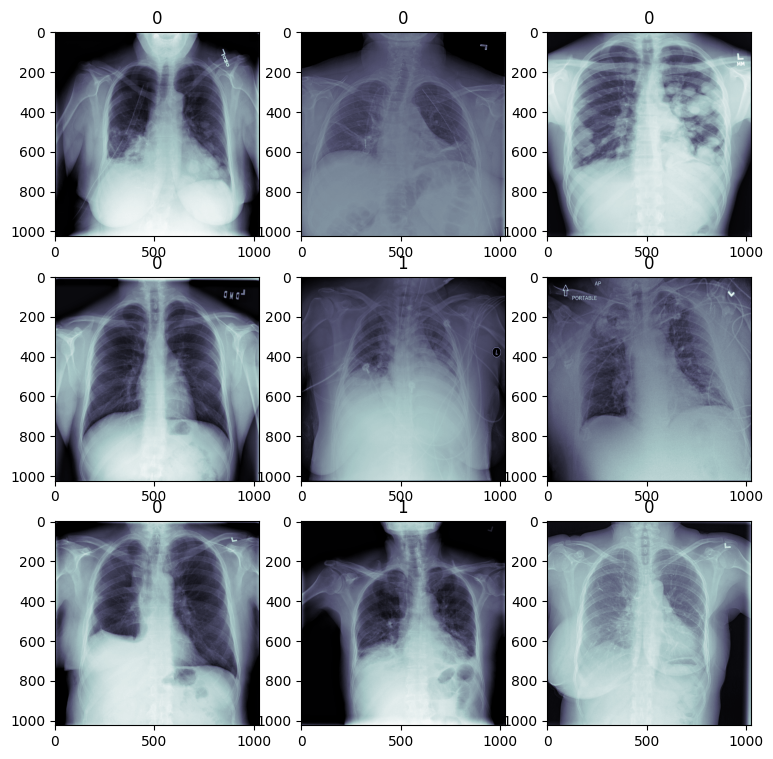

In [13]:
fig, axis = plt.subplots(3,3, figsize=(9,9))
# set up counter
c=0
# for loop
for i in range(3):
  for j in range(3):
    ## These are the steps to extract each DICOM file
    # 1. extract patientID
    patient_id = labels.patientId.iloc[c]
    # 2. get DICOM patient id
    dcm_path = ROOT_PATH/patient_id
    # 3. setup DICOM file path
    dcm_path = dcm_path.with_suffix(".dcm")
    # 4. read DICOM files - extract pixel arrays
    dcm = pydicom.read_file(dcm_path).pixel_array


    # extract from labels df
    label = labels["Target"].iloc[c]

    # get image with title
    axis[i][j].imshow(dcm, cmap="bone") #can be "gray" too
    axis[i][j].set_title(label)
    # add to count variable
    c+=1

Summary of visualization:
* We now have a 3x3 grid with some of the x-ray images visualized.
* We can also see the labels assigned to each image:
    * 1 = "pneumonia positive"
    * 0 = "pneumonia negative"

In [14]:
## what are the shapes of the images?
dcm.shape

(1024, 1024)

Summary: We can see as we mentioned earlier the image shapes are 1024, 1024 and we will need to resize them to smaller shapes to work with our CNN model.

# Load and Preprocess Dataset

In [ ]:
#
sums, sums_squared = 0, 0

# loop over and preproces data
for c, patient_id in enumerate(tqdm(labels.patientId)):
  # Steps to extract full path of DICOM file
  # 1. extract patientID
    patient_id = labels.patientId.iloc[c]
    # 2. get DICOM patient id
    dcm_path = ROOT_PATH/patient_id
    # 3. setup DICOM file path
    dcm_path = dcm_path.with_suffix(".dcm")
    # 4. read DICOM files - extract pixel arrays => standardize => divide pixel_array/255
    dcm = pydicom.read_file(dcm_path).pixel_array / 255

    # Step: Pre-process the x-ray image
    ## Resize the image from 1024,1024 --> 224,224 and store as float16 for less memory storage
    dcm_array = cv2.resize(dcm, (224,224)).astype(np.float16)

    # store x-ray labels
    label = labels.Target.iloc[c]

    # Store image in train or val directory
    train_or_val = "train" if c < 24000 else "val"

    # current save_path
    current_save_path = SAVE_PATH/train_or_val/str(label) #pathlib cant handle integers
    current_save_path.mkdir(parents=True, exist_ok=True)
    np.save(current_save_path/patient_id, dcm_array) #save patient_id and dicom array

    # normalize the pixel arrays
    normalizer = 224*224
    if train_or_val == "train":
      sums += np.sum(dcm_array) / normalizer
      sums_squared += (dcm_array ** 2).sum() / normalizer


## Last step: Convert sums and sums_squared into means and std
* Recall the reason for doing this:
    * We Compute training set mean and standard deviation for normalization of data
    * Why? Dataset does not fit into memory
    * This "trick" is thus used to compute mean and standard deviation
    * Compute sum of x and sum of x**2 for each image X and add these values to the global variable sums and sums_squared.
    * **This is done for all pixels.**

In [ ]:
#mean
mean = sums / 24000

#std
std = np.sqrt((sums_squared / 24000) - mean**2)

In [ ]:
## print mean, std calculations
mean, std

Summary:
* The computed mean and std above we can then use to normalize our dataset.